In [58]:
from transformers import BertModel, BertTokenizer
import torch
import numpy as np
from sklearn.metrics import pairwise_distances
import json
from google.colab import drive
import heapq
import math
import matplotlib.pyplot as plt

In [59]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [60]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [61]:
playlists_file_path = '/content/drive/My Drive/puc/rec/project/data/playlistid_itemid_1000p.txt'

In [62]:
def read_interactions(file):
  ui_mat = np.loadtxt(f'{file}', dtype=np.int32)
  return ui_mat

In [63]:
interactions = read_interactions(playlists_file_path)
print(interactions.shape)
print(interactions)

(67503, 2)
[[    0  9700]
 [    0 22032]
 [    0  8608]
 ...
 [  999 12708]
 [  999 16485]
 [  999  5361]]


In [64]:
tracks_per_playlist = []
last_playlist_id = interactions[0][0]
tracks_count = 0
for interaction in interactions:
  playlist_id = interaction[0]
  track_id = interaction[1]
  if playlist_id != last_playlist_id:
    tracks_per_playlist.append(tracks_count)
    tracks_count = 0
    last_playlist_id = playlist_id
  if playlist_id == last_playlist_id:
    tracks_count += 1
tracks_per_playlist.append(tracks_count)

In [65]:
import seaborn as sns

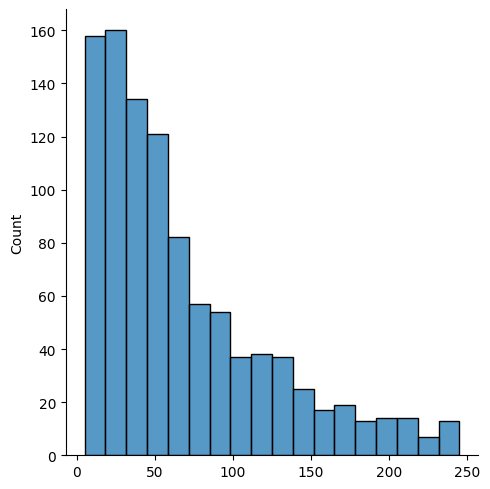

In [66]:
sns.displot(tracks_per_playlist)

In [67]:
len([tc for tc in tracks_per_playlist if tc >= 25])

758

In [68]:
test_partition_portion = 0.2
test_partition_required_samples = int(len(tracks_per_playlist)*test_partition_portion)
print(f'A continuación se seleccionan las {test_partition_required_samples} playlist requeridas para test')

A continuación se seleccionan las 200 playlist requeridas para test


In [69]:
selectable_playlists_idx = [idx for idx ,tc in enumerate(tracks_per_playlist) if tc >= 30]

In [70]:
from sklearn.model_selection import train_test_split

In [71]:
train_playlists_idx, test_playlist_idx = train_test_split(selectable_playlists_idx, test_size=test_partition_required_samples, random_state=87)

In [72]:
test_playlist_idx = np.sort(test_playlist_idx)

In [73]:
train_playlists_idx = np.sort(train_playlists_idx)

In [74]:
print(interactions.shape)

(67503, 2)


In [75]:
train_interactions = []
test_interactions = []
for interaction in interactions:
  playlist_id = interaction[0]
  if playlist_id not in test_playlist_idx:
    train_interactions.append(interaction)
  if playlist_id in test_playlist_idx:
    test_interactions.append(interaction)

In [76]:
print(len(train_interactions))
print(len(test_interactions))
print(len(train_interactions) + len(test_interactions))

50888
16615
67503


In [77]:
test_interactions.sort(key = lambda x: x[0])

In [78]:
last_playlist_id = test_interactions[0][0]
tracks_count = 0
n = 30
test_interactions_n_per_playlist = []
for interaction in test_interactions:
  playlist_id = interaction[0]
  track_id = interaction[1]
  if playlist_id == last_playlist_id and tracks_count < n:
    test_interactions_n_per_playlist.append(interaction)
    tracks_count += 1
  if playlist_id != last_playlist_id:
    test_interactions_n_per_playlist.append(interaction)
    tracks_count = 1
    last_playlist_id = playlist_id

In [79]:
print(f'Total de interacciones de test {len(test_interactions_n_per_playlist)}')
print(f'(test_playlist x n) ({test_partition_required_samples} x {n}) = {test_partition_required_samples*n}')

Total de interacciones de test 6000
(test_playlist x n) (200 x 30) = 6000


In [80]:
def save_txt_file(file_path, data):
    with open(file_path, 'w') as file:
        for item in data:
            file.write(f"{item[0]} {item[1]}\n")

In [81]:
train_interactions_file_path = '/content/drive/My Drive/puc/rec/project/data/playlistid_itemid_1000p_train.txt'
test_challenge_file_path = '/content/drive/My Drive/puc/rec/project/data/test_challenge_200p.txt'
save_txt_file(train_interactions_file_path, train_interactions)
save_txt_file(test_challenge_file_path, test_interactions_n_per_playlist)

In [82]:
last_playlist_id = test_interactions[0][0]
tracks_count = 0
n = 5
test_interactions_n_per_playlist = []
for interaction in test_interactions:
  playlist_id = interaction[0]
  track_id = interaction[1]
  if playlist_id == last_playlist_id and tracks_count < n:
    test_interactions_n_per_playlist.append(interaction)
    tracks_count += 1
  if playlist_id != last_playlist_id:
    test_interactions_n_per_playlist.append(interaction)
    tracks_count = 1
    last_playlist_id = playlist_id

In [83]:
print(f'Total de interacciones de test {len(test_interactions_n_per_playlist)}')
print(f'(test_playlist x n) ({test_partition_required_samples} x {n}) = {test_partition_required_samples*n}')

Total de interacciones de test 1000
(test_playlist x n) (200 x 5) = 1000
